<a href="https://colab.research.google.com/github/ABD-01/MNIST/blob/main/Triplet%20Loss/TRIPLET_LOSS_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from itertools import combinations 
 
import tensorflow as tf
 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
 
import torchvision
import torchvision.transforms as transforms

In [2]:
# plt.rcParams['figure.figsize'] = (5, 5)

# Utils

In [3]:
def triplet_loss(anchor, positive, negative, margin=0.2):
    pos_dist = (anchor - positive).pow(2).sum(-1) #.pow(.5)
    neg_dist = (anchor - negative).pow(2).sum(-1) #.pow(.5)
    loss = F.relu(pos_dist - neg_dist + margin)
    return loss.mean()
 
# ref: https://github.com/adambielski/siamese-triplet/blob/master/losses.py#L24

In [4]:
def tf_triplet_loss(anchor, positive, negative, margin=0.2):  
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
    loss = tf.maximum(pos_dist - neg_dist + margin, 0)
    return tf.reduce_mean(loss)
 
# ref : https://stackoverflow.com/questions/38260113/implementing-contrastive-loss-and-triplet-loss-in-tensorflow/38270293#38270293

In [5]:
torch_triplet_loss = nn.TripletMarginLoss(margin=0.2)

In [6]:
def get_all_triplets(embeddings:list, targets:list) -> list:
    '''
    Parameters
    ----------
    embeddings : list of torch.tensor
    targets    : list of ints

    Returns
    -------
    triplets   : list of tuple
    '''

    # eg : no(targets) = 3
    # eg : no(embeds) = 10

    assert len(embeddings) == len(targets) , "Embeddings and Targets must have same lenght"

    triplets = []
    for i, anchor in enumerate(embeddings):

        positive_pairs = list(combinations(anchor,2))  # this will give of distinct pairs of elements 
                                                                 # no(pos_pairs) = no(targets)P2 / 2!  # eg : 45
        
        temp = embeddings.pop(i)  # embeddings list except the anchor
        for negative_embeddings in torch.cat(embeddings,dim=0):   # loops runs for no(targets)-1 * no(embeds) times  # eg : (3-1)*10=20 
            
            triple = [(positive_pair[0], positive_pair[1], negative_embeddings) for positive_pair in positive_pairs]  # no(triple) = n(pos_pair) # eg: 45
            
            triplets.extend(triple)   # no. of triplets added = no(pos_pairs)*(no(targets) - 1)*(no(embeds))  # eg: 45*2*10=900

        embeddings.insert(i, temp)

    return triplets  # no(triplets) = no(added_triples) * no(embeds) # eg: 900*3 = 2700

# ref : A lot can't even even mention here

In [7]:
def get_all_tensor_triplets(embeddings:list, targets:list) -> list:
    '''
    Parameters
    ----------
    embeddings : list of torch.tensor each of shape torch.Size([?, 128])
    targets    : list of ints

    Returns
    -------
    triplets   : torch.tensor of shape torch.Size([?, no(triplets), 3])
    '''

    # eg : no(targets) = 3
    # eg : no(embeds) = 10

    assert len(embeddings) == len(targets) , "Embeddings and Targets must have same lenght"

    triplets = []
    for i, anchor in enumerate(embeddings):

        positive_pairs = list(combinations(anchor,2))  # this will give of distinct pairs of elements 
                                                                 # no(pos_pairs) = no(targets)P2 / 2!  # eg : 45
        
        temp = embeddings.pop(i)  # embeddings list except the anchor
        for negative_embeddings in torch.cat(embeddings,dim=0):   # loops runs for no(targets)-1 * no(embeds) times  # eg : (3-1)*10=20 
            
            triple = [torch.stack([positive_pair[0], positive_pair[1], negative_embeddings], dim=0) for positive_pair in positive_pairs]  # no(triple) = n(pos_pair) # eg: 45
            
            triplets.extend(triple)   # no. of triplets added = no(pos_pairs)*(no(targets) - 1)*(no(embeds))  # eg: 45*2*10=900

        embeddings.insert(i, temp)

    return torch.stack(triplets, dim=0)  # no(triplets) = no(added_triples) * no(embeds) # eg: 900*3 = 2700

# ref : A lot can't even even mention here

In [8]:
def get_random_triplets(embeddings:list,  targets:list) -> torch.Tensor:
    '''
    For each image in data (Anchor), randomly sample a Positive image from its class.  
    Then from each of the other classes sample one image (randomly) as the Negative. Hence, for every Anchor
    you will have 1 randomly selected positive from it's class and randomly selected Negative from each of the n-1 classes 
    where n is total number of classes.  For every Anchor image you would have n-1 triplets.
    So if you're having 3 classes of 10 images each then you would have 60 triplets. 
    '''


    assert len(embeddings) == len(targets) , "Embeddings and Targets must have same lenght"

    triplets = []
    for i, embedding in enumerate(embeddings):
        temp = embeddings.pop(i)

        for anchor in embedding:
            positive = random.choice(embedding)

            for negatives in embeddings:
                negative = random.choice(negatives)

                triplets.append(torch.stack([anchor, positive, negative], dim=0))

        embeddings.insert(i, temp)

    return torch.stack(triplets, dim=0)  


In [9]:
MNIST_train = torchvision.datasets.MNIST(
    root = '/content/drive/MyDrive/Colab Notebooks/',
    download = True,
    train = True,
    transform = transforms.ToTensor()
)

In [10]:
MNIST_train.data.shape

torch.Size([60000, 28, 28])

4

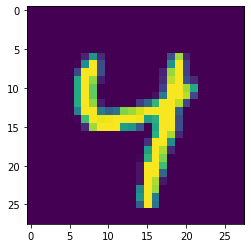

In [11]:
i =5734
plt.imshow(MNIST_train[i][0].squeeze())
MNIST_train[i][1]

## Reorganizing Data

In [12]:
train_dict = {i : MNIST_train.data[MNIST_train.targets == i].unsqueeze(1) / 255 for i in range(10)}
print(*[f'{imgs.shape[0]} images of Label {label} of shape {imgs.shape[1:]}' for label, imgs in train_dict.items()], sep='\n')
# for i in range(10):
#     train_dict[i] = MNIST_train.data[MNIST.targets == i]

5923 images of Label 0 of shape torch.Size([1, 28, 28])
6742 images of Label 1 of shape torch.Size([1, 28, 28])
5958 images of Label 2 of shape torch.Size([1, 28, 28])
6131 images of Label 3 of shape torch.Size([1, 28, 28])
5842 images of Label 4 of shape torch.Size([1, 28, 28])
5421 images of Label 5 of shape torch.Size([1, 28, 28])
5918 images of Label 6 of shape torch.Size([1, 28, 28])
6265 images of Label 7 of shape torch.Size([1, 28, 28])
5851 images of Label 8 of shape torch.Size([1, 28, 28])
5949 images of Label 9 of shape torch.Size([1, 28, 28])


In [13]:
label = 7
rand_imgs = train_dict[label][random.sample(range(1, 5000), 100)]
grid = torchvision.utils.make_grid(rand_imgs, nrow=10, pad_value=20)
# ref: https://pytorch.org/vision/stable/utils.html#torchvision-utils

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


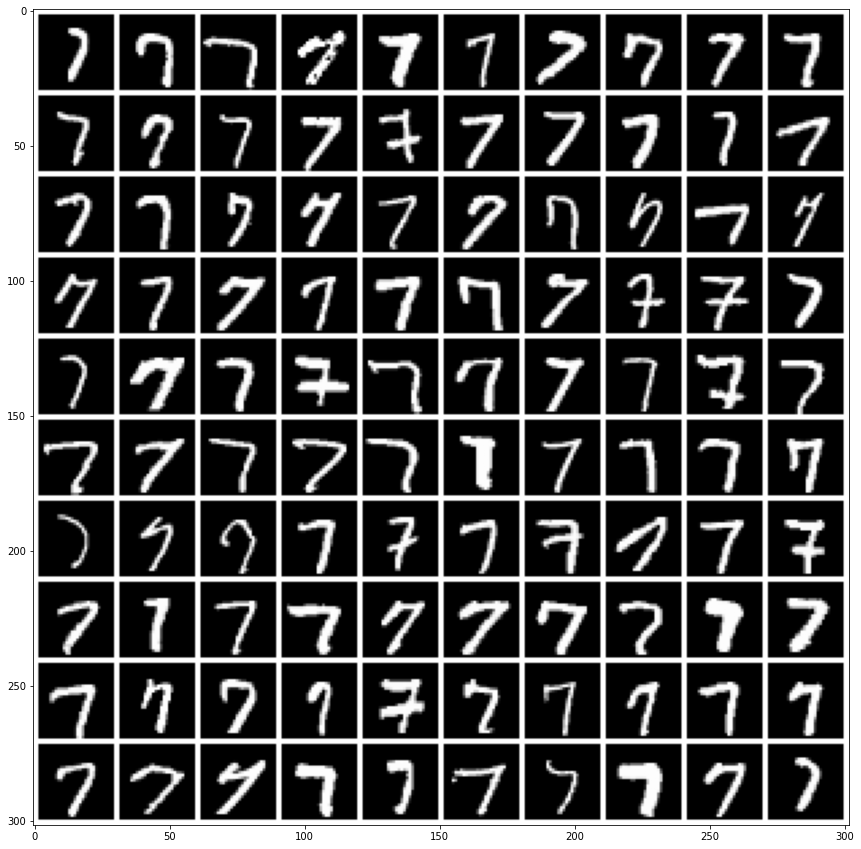

In [14]:
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))

Image Processing 

In [15]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Normalize(mean=0.1307, std=0.3081),
    transforms.Lambda(lambda image: torch.cat((image,image,image), dim=-3)),
])
# ref: https://pytorch.org/hub/pytorch_vision_resnet/

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


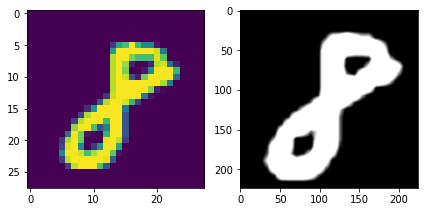

In [16]:
timg = train_dict[8][1]  # shape = (1,28,28)
ptimg = preprocess(timg)  # shape = (3,224,224)

_, axarr = plt.subplots(1,2, figsize = (7,7)) 

axarr[0].imshow(timg.squeeze())

axarr[1].imshow(torch.movedim(ptimg, -3, -1))
#ref : https://pytorch.org/docs/stable/generated/torch.movedim.html

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


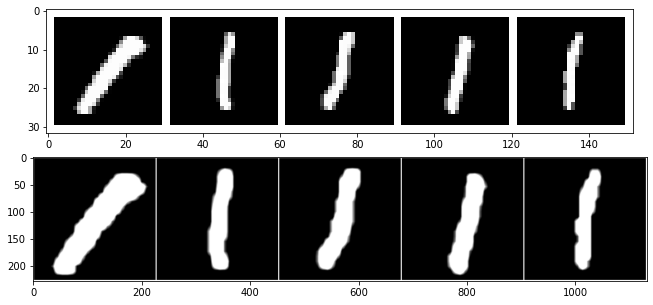

In [17]:
rand_imgs = train_dict[1][random.sample(range(1, 5000), 5)]  # shape = (5,1,28,28)
grid = torchvision.utils.make_grid(rand_imgs, nrow=5, pad_value=20)

prand_imgs = preprocess(rand_imgs)  # shape = (5,3,224,224)
pgrid = torchvision.utils.make_grid(prand_imgs, nrow=5, pad_value=20)

fig , axarr = plt.subplots(2,1, figsize = (15,5)) 

axarr[0].imshow(np.transpose(grid, (1,2,0)))
axarr[1].imshow(np.transpose(pgrid, (1,2,0)))

# Creating Model

In [18]:
# Self defined CNN Model


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.preprocess = transforms.Compose([
                            transforms.Resize(256),
                            transforms.CenterCrop(224),
                            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                            transforms.Normalize(mean=0.1307, std=0.3081),
                            transforms.Lambda(lambda image: torch.cat((image,image,image), dim=-3)),
                        ])
        # ref: https://pytorch.org/hub/pytorch_vision_resnet/

        self.convnet1 = nn.Sequential(
                            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2),
                            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.convnet2 = nn.Sequential(
                            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
                            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.convnet3 = nn.Sequential(
                            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2),
                            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.FCs      = nn.Sequential(
                            nn.Linear(in_features=4096, out_features=2048), nn.ReLU(),
                            nn.Linear(in_features=2048, out_features=512), nn.ReLU(),
                            nn.Linear(in_features=512, out_features=128), nn.ReLU()
        )
        self.out      = nn.Linear(in_features=128, out_features=2)


    def forward(self, x):
        x = self.preprocess(x)
        x = self.convnet1(x)
        x = self.convnet2(x)
        x = self.convnet3(x)
        x = x.reshape(-1, 4*4*256)
        x = self.FCs(x)
        enc = self.out(x)
        return enc

        

In [19]:
'''
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.preprocess = transforms.Compose([
                            transforms.Resize(256),
                            transforms.CenterCrop(224),
                            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                            transforms.Normalize(mean=0.1307, std=0.3081),
                            transforms.Lambda(lambda image: torch.cat((image,image,image), dim=-3)),
                        ])
        # ref: https://pytorch.org/hub/pytorch_vision_resnet/

        self.resnet18 = torchvision.models.resnet18(pretrained=False)
        self.out = nn.Linear(in_features=1000, out_features=128)

    def forward(self, images):
        images = self.preprocess(images)
        images = self.resnet18(images)
        encodings = self.out(images)

        return encodings
'''


'\nclass Model(nn.Module):\n    def __init__(self):\n        super(Model, self).__init__()\n        self.preprocess = transforms.Compose([\n                            transforms.Resize(256),\n                            transforms.CenterCrop(224),\n                            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),\n                            transforms.Normalize(mean=0.1307, std=0.3081),\n                            transforms.Lambda(lambda image: torch.cat((image,image,image), dim=-3)),\n                        ])\n        # ref: https://pytorch.org/hub/pytorch_vision_resnet/\n\n        self.resnet18 = torchvision.models.resnet18(pretrained=False)\n        self.out = nn.Linear(in_features=1000, out_features=128)\n\n    def forward(self, images):\n        images = self.preprocess(images)\n        images = self.resnet18(images)\n        encodings = self.out(images)\n\n        return encodings\n'

# Visualizing Model

In [20]:
model = Model()
model

Model(
  (convnet1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2))
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convnet2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convnet3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
    (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (FCs): Sequential(
    (0): Linear(in_features=4096, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=128, bias=True)
   

In [21]:
!pip install torchviz

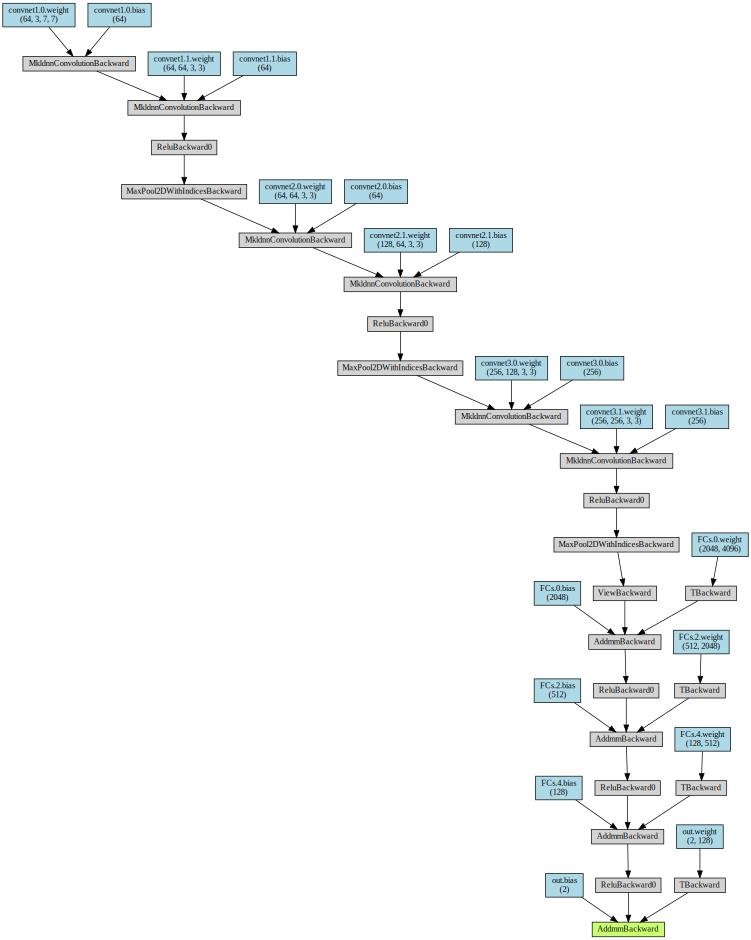

In [22]:
from torchviz import make_dot

x = torch.randn(10,1,28,28)

make_dot(model(x), params=dict(model.named_parameters()))   

# ref : https://github.com/szagoruyko/pytorchviz/blob/master/examples.ipynb

In [23]:
!pip install git+https://github.com/waleedka/hiddenlayer.git

  Cloning https://github.com/waleedka/hiddenlayer.git to /tmp/pip-req-build-s_ag1uuw
  Running command git clone -q https://github.com/waleedka/hiddenlayer.git /tmp/pip-req-build-s_ag1uuw
  Created wheel for hiddenlayer: filename=hiddenlayer-0.2-cp36-none-any.whl size=19771 sha256=1fa64e5cd14c48fbf16b3a5545cd11885dcf226f329591bd6747d0b2d9e112ac
  Stored in directory: /tmp/pip-ephem-wheel-cache-vmklreg4/wheels/49/bc/d1/938073704abdd049b3e4cdc6811c8f468d69fb5eecc6e01748
Successfully built hiddenlayer


/usr/local/lib/python3.6/dist-packages/torch/onnx/symbolic_helper.py:267: UserWarning: You are trying to export the model with onnx:Upsample for ONNX opset version 9. This operator might cause results to not match the expected results by PyTorch.
ONNX's Upsample/Resize operator did not match Pytorch's Interpolation until opset 11. Attributes to determine how to transform the input were added in onnx:Resize in opset 11 to support Pytorch's behavior (like coordinate_transformation_mode and nearest_mode).
We recommend using opset 11 and above for models using this operator. 
  "" + str(_export_onnx_opset_version) + ". "


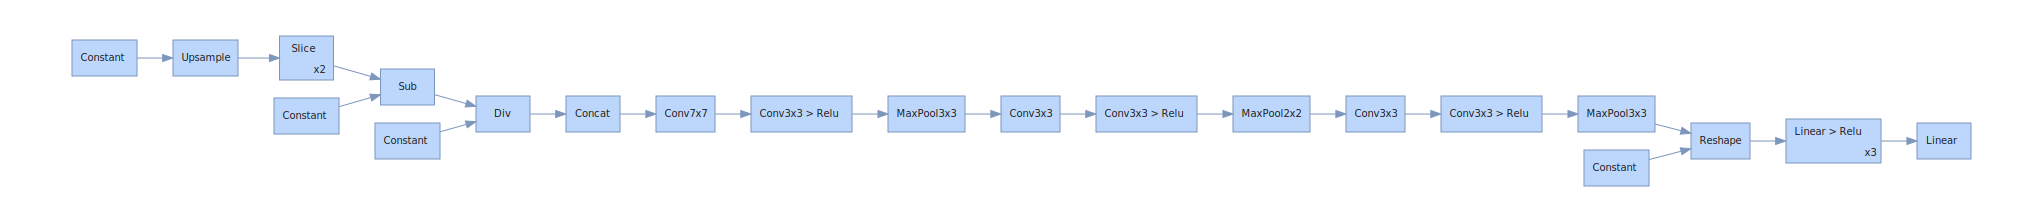

In [24]:
import hiddenlayer as hl

# Build HiddenLayer graph
hl_graph = hl.build_graph(model, torch.zeros([1, 1, 28, 28]))

# Use a different color theme
hl_graph.theme = hl.graph.THEMES["blue"].copy()  # Two options: basic and blue
hl_graph

#ref : https://github.com/waleedka/hiddenlayer/blob/master/demos/pytorch_graph.ipynb

In [25]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
 
def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(3):
        plt.scatter(embeddings[i].detach().numpy()[:,0],embeddings[i].detach().numpy()[:,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(targets)

# ref: https://github.com/adambielski/siamese-triplet/blob/master/Experiments_MNIST.ipynb

# Running the Model

In [26]:
model = Model()

learning_rate = 0.001
lossfn = triplet_loss
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)


In [27]:
zeros_images = train_dict[0][:100]
ones_images  = train_dict[1][:100]
twos_images  = train_dict[2][:100]

images = torch.stack([zeros_images, ones_images, twos_images], dim=1)
images.shape

torch.Size([100, 3, 1, 28, 28])

In [28]:
images[:,0,...].shape

torch.Size([100, 1, 28, 28])

In [29]:
loader = torch.utils.data.DataLoader(images, batch_size=10)
len(loader)

10

In [30]:
sample = next(iter(loader))
sample.shape

torch.Size([10, 3, 1, 28, 28])

In [31]:
enc0 = []
enc1 = []
enc2 = []
for batch in loader:
    enc0.append(model(batch[:,0,...]))
    enc1.append(model(batch[:,1,...]))
    enc2.append(model(batch[:,2,...]))
enc0 = torch.cat(enc0)
enc1 = torch.cat(enc1)
enc2 = torch.cat(enc2)
enc0.shape, enc1.shape, enc2.shape

(torch.Size([100, 2]), torch.Size([100, 2]), torch.Size([100, 2]))

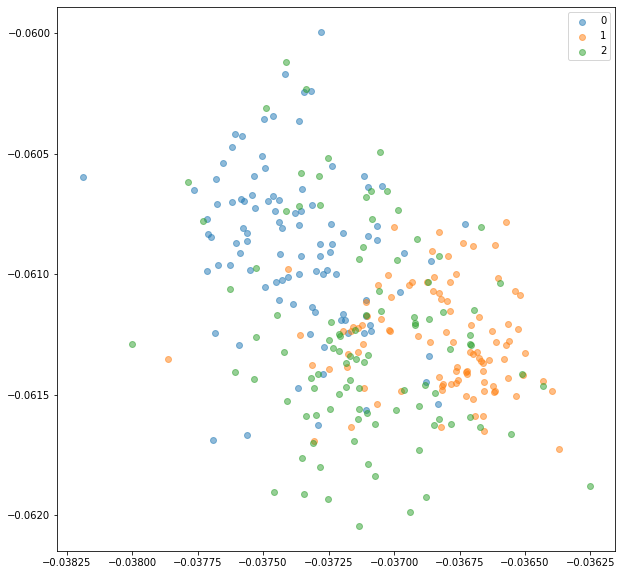

In [32]:
plot_embeddings(embeddings=[enc0, enc1, enc2], targets=[0,1,2])

In [33]:
# zeros_images = train_dict[0][:100]
# ones_images  = train_dict[1][:100]
# twos_images  = train_dict[2][:100]

# triplets = get_random_triplets([zeros_images, ones_images, twos_images], [0, 1, 2])

# cost = []

# epochs = 5
# for epoch in range(epochs):
#     anchor    = model(triplets[:,0,...])
#     positive  = model(triplets[:,1,...])
#     negative  = model(triplets[:,2,...])

#     optimizer.zero_grad()
#     loss = lossfn(anchor, positive, negative, margin=1)
#     cost.append(loss)

    
#     loss.backward(retain_graph=True)
#     optimizer.step()

#     print(f'Epoch:[{epoch+1}/{epochs}] , Cost : {loss.item()}')


In [34]:
# zeros_images = train_dict[0][:100]
# ones_images  = train_dict[1][:100]
# twos_images  = train_dict[2][:100]

cost = []

epochs = 5
for epoch in range(epochs):
    for batch in loader:
        zeros_encodings = model(batch[:,0,...])
        ones_encodings  = model(batch[:,1,...])
        twos_encodings  = model(batch[:,2,...])

        triplets = get_random_triplets([zeros_encodings, ones_encodings, twos_encodings], [0, 1, 2])

        anchor   = triplets[:,0]
        positive = triplets[:,1]
        negative = triplets[:,2]

        optimizer.zero_grad()
        loss = lossfn(anchor, positive, negative, margin=1)
        cost.append(loss)

        
        loss.backward()
        optimizer.step()

        print(f'Epoch:[{epoch+1}/{epochs}] , Cost : {loss.item()}')


Epoch:[1/5] , Cost : 1.0000001192092896
Epoch:[1/5] , Cost : 0.9997758865356445
Epoch:[1/5] , Cost : 0.7588456273078918
Epoch:[1/5] , Cost : 1.685768485069275
Epoch:[1/5] , Cost : 0.8642358779907227
Epoch:[1/5] , Cost : 0.9239748120307922
Epoch:[1/5] , Cost : 0.8487627506256104
Epoch:[1/5] , Cost : 0.5361992120742798
Epoch:[1/5] , Cost : 0.24667228758335114
Epoch:[1/5] , Cost : 0.67702716588974
Epoch:[2/5] , Cost : 0.5117005109786987
Epoch:[2/5] , Cost : 0.47465890645980835
Epoch:[2/5] , Cost : 0.2975076138973236
Epoch:[2/5] , Cost : 0.24823036789894104
Epoch:[2/5] , Cost : 0.0701005607843399
Epoch:[2/5] , Cost : 0.06190096586942673
Epoch:[2/5] , Cost : 0.4110758900642395
Epoch:[2/5] , Cost : 0.5814176797866821
Epoch:[2/5] , Cost : 0.29250267148017883
Epoch:[2/5] , Cost : 0.5115802884101868
Epoch:[3/5] , Cost : 0.35036876797676086
Epoch:[3/5] , Cost : 0.07252687960863113
Epoch:[3/5] , Cost : 0.13304764032363892
Epoch:[3/5] , Cost : 0.08237586915493011
Epoch:[3/5] , Cost : 0.10571669787

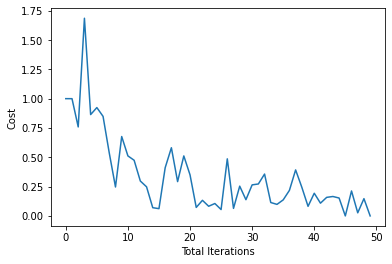

In [35]:
plt.xlabel('Total Iterations')
plt.ylabel('Cost')
plt.plot(np.arange(epochs*len(loader)), cost)
plt.show()

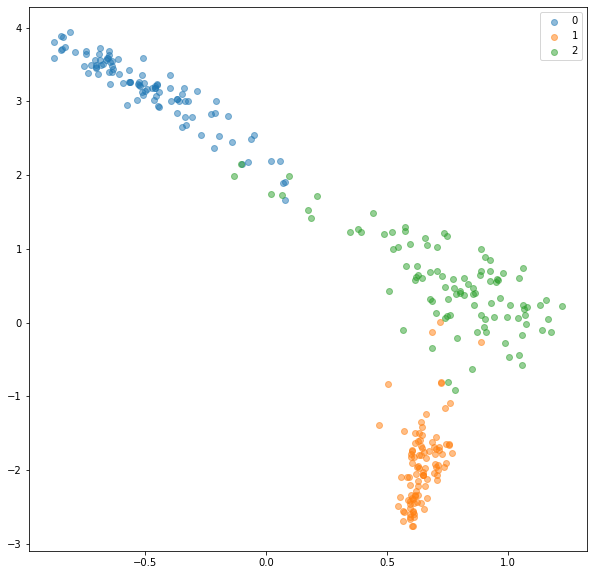

In [47]:
enc0 = []
enc1 = []
enc2 = []
for batch in loader:
    enc0.append(model(batch[:,0,...]))
    enc1.append(model(batch[:,1,...]))
    enc2.append(model(batch[:,2,...]))
enc0 = torch.cat(enc0)
enc1 = torch.cat(enc1)
enc2 = torch.cat(enc2)
plot_embeddings([enc0, enc1, enc2], [0,1,2])

In [37]:
zeros_encodings.sum(-1).shape

torch.Size([10])

In [38]:
(zeros_encodings - ones_encodings).pow(2).sum(-1)

tensor([42.2152, 32.4020, 31.1984, 27.2169, 29.2056, 34.9288, 32.9784, 29.4513,
        24.4675, 34.7783], grad_fn=<SumBackward1>)

In [39]:
(zeros_encodings - twos_encodings).pow(2).sum(-1)

tensor([ 7.0696,  7.8798,  7.7398,  7.6575, 13.9389, 15.3890,  6.6349,  7.1431,
        10.4654,  9.3317], grad_fn=<SumBackward1>)

In [40]:
(zeros_encodings - zeros_encodings).pow(2).sum(-1)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<SumBackward1>)

In [41]:
(ones_encodings - twos_encodings).pow(2).sum(-1)

tensor([15.4420, 10.1248,  9.3986,  6.7666,  3.1468,  4.3175, 10.7462,  8.3022,
         3.3345,  9.4191], grad_fn=<SumBackward1>)

In [42]:
(anchor - positive).pow(2).sum(-1)

tensor([0.1251, 0.1251, 0.2405, 0.2405, 0.0000, 0.0000, 0.9788, 0.9788, 0.0611,
        0.0611, 0.4675, 0.4675, 0.2116, 0.2116, 0.2836, 0.2836, 0.6484, 0.6484,
        0.9788, 0.9788, 0.2175, 0.2175, 0.0045, 0.0045, 0.0408, 0.0408, 0.2355,
        0.2355, 0.4728, 0.4728, 0.0110, 0.0110, 0.6332, 0.6332, 0.4917, 0.4917,
        0.4191, 0.4191, 0.0999, 0.0999, 0.2409, 0.2409, 0.1040, 0.1040, 0.3740,
        0.3740, 0.1983, 0.1983, 0.1444, 0.1444, 0.0048, 0.0048, 0.2409, 0.2409,
        1.2786, 1.2786, 1.2542, 1.2542, 0.0000, 0.0000],
       grad_fn=<SumBackward1>)

In [43]:
(anchor - negative).pow(2).sum(-1)

tensor([36.5385,  8.2152, 34.6845, 10.4208, 25.9286,  4.1622, 24.1929,  8.9805,
        29.2056,  7.5979, 31.7946,  9.0282, 31.9978,  4.9270, 32.5480,  6.5071,
        23.9916,  4.2025, 44.1190,  9.3317, 40.1680,  9.5181, 37.4831, 12.0146,
        31.9978, 12.8587, 29.0457,  8.0939, 24.7488,  4.5851, 26.7924,  5.7691,
        38.0662, 10.0023, 23.9918,  3.0867, 31.3822,  4.7461, 33.9558,  7.1334,
         8.0439,  8.8809,  9.9109, 10.1248,  8.0371,  9.3986, 12.0409,  4.5044,
        14.1064,  3.7693, 10.5203,  3.2266,  9.1998,  8.8976,  8.4297, 11.4305,
        10.4654,  6.5855,  7.5979,  8.3294], grad_fn=<SumBackward1>)

In [44]:
triplets = get_triplets([zeros_encodings, ones_encodings, twos_encodings], [0, 1, 2])

anchor = torch.stack([triple[0] for triple in triplets])
positive = torch.stack([triple[1] for triple in triplets])
negative = torch.stack([triple[2] for triple in triplets])

NameError: ignored

In [ ]:
triplet_loss(anchor, positive, negative)

In [ ]:
anchor.shape

In [ ]:
plt.imshow(train_dict[1][47].squeeze())

In [ ]:
test_emb = model(train_dict[3][42].unsqueeze(0))
test_emb1 = model(train_dict[1][47].unsqueeze(0))

In [ ]:
(test_emb1 - ones_encodings[0]).pow(2).sum(-1)

In [ ]:
(test_emb1 - twos_encodings[0]).pow(2).sum(-1)

In [ ]:
(test_emb1 - zeros_encodings[0]).pow(2).sum(-1)

In [ ]:
(test_emb - test_emb1).pow(2).sum(-1)

In [ ]:
zeros_encodings[0].shape

## Random Testings

In [ ]:
a = torch.rand(100,1,28,28)
b = torch.rand(100,1,28,28)
c = torch.rand(100,1,28,28)

In [ ]:
trp = get_all_tensor_triplets([a,b,c], (1,2,3))

In [ ]:
trp.shape

In [ ]:
trp[:,0,...].shape

In [ ]:
trp_loader = torch.utils.data.DataLoader(rt, batch_size=20)

In [ ]:
torch.cat([i for i in trp_loader]).shape

In [ ]:
len(trp_loader)

In [ ]:
for i in trp_loader:
    print(i.shape)

In [ ]:
rt = get_random_triplets([a,b,c], [1,2,3])

In [ ]:
rt.shape

In [ ]:
a = torch.rand(5,3,4)*10
print(a.shape)
a

In [ ]:
a = torch.rand(2,5)
p = torch.rand(2,5)
n = torch.rand(2,5)
a,p,n

In [ ]:
t = get_triplets([a,p,n], [0,1,2])
len(t)
# type(t[2699])
# len(t[2699][0])
# type(t[2699][0])
for _ in t: print(_, end="\n\n")

In [ ]:
tt = get_tensor_triplets([a,p,n], [0,1,2])

In [ ]:
type(tt)
tt.shape
# tt[:,0].shape
tt[:,0] #.shape

In [ ]:
exp = torch.rand(2700,1,28,28)
m = Model()

In [ ]:
t = m(exp)
t.shape

In [ ]:
t = m.convnet2(t)
t.shape

In [ ]:
t = m.convnet3(t)
t.shape

In [ ]:
t1 = t.reshape(-1, 4096)
t1.shape

In [ ]:
self.FCs      = nn.Sequential(
                            nn.Linear(in_features=4096, out_features=2048),
                            nn.Linear(in_features=2048, out_features=512),
                            nn.Linear(in_features=512, out_features=128)
        )

In [ ]:
t1 = m.FCs(t1)
t1.shape

In [ ]:
t1 = m.out(t1)
t1.shape

In [ ]:
t.shape